# Amplitude damping experience
#### Todo: Need to document

In [1]:
import sys
import numpy as np
sys.path.append("../")
import qiskit.backends.local.qasm_simulator_cpp as qs
SIM_EXECUTABLE = '../../yael_branch/qiskit-sdk-py/out/qiskit_simulator'
def generate_counts_vec(sim_output):
    """Returns ndarray of length 8 which contains result counts devided by shots_num"""
    vec = np.zeros(8, dtype=int)
    for i, count in sim_output['result'][0]['data']['counts'].items():
        vec[int(i, 2)] = count
        
    return vec[np.newaxis] / sim_output['result'][0]['shots']

def matrices_calc(g):
    """
    Returns two matrices of size 2x2:
    E0 = [
            [1,0],
            [0, sqrt(1-g)]
         ]
         
    E1 = [
            [0, sqrt(g)],
            [0,0]
         ]
    """
    assert 0 < g < 1, "Gamma (g) must be between zero to one"
    return [[[1, 0], [0, np.sqrt(1-g)]], [[0, np.sqrt(g)], [0, 0]]]

def p_calc(g):
    """
    Returns p out of Gamma - g/2 + 0.5*sqrt(1-g) + 0.5
    """
    assert 0 < g < 1, "Gamma (g) must be between zero to one"
    return g/2 - 0.5*np.sqrt(1-g) + 0.5

def t_calc(p, r):
    return -(np.log(1-p))/r

def prepare_qobj_exact(qobj, gamma):
    qobj['config']['backend'] = 'local_qasm_simulator_cpp'
    qobj['config']['noise_params'] = {}
    qobj['config']['noise_params']['U'] = {}
    qobj['config']['noise_params']['U']['operator_sum'] = matrices_calc(gamma)
    qobj['config']['noise_params']['CX'] = {}
    qobj['config']['noise_params']['CX']['operator_sum'] = matrices_calc(gamma)

    
def prepare_qobj_clifford(qobj, gamma, r):
    qobj['config']['backend'] = 'local_clifford_simulator_cpp'
    qobj['config']['noise_params'] = {}
    qobj['config']['noise_params']['relaxation_rate'] = r
    qobj['config']['noise_params']['thermal_populations'] = [1.0, 0.0]
    qobj['config']['noise_params']['U'] = {}
    qobj['config']['noise_params']['U']['gate_time'] = t_calc(p_calc(gamma), r)
    qobj['config']['noise_params']['CX'] = {}
    qobj['config']['noise_params']['CX']['gate_time'] = t_calc(p_calc(gamma), r)
#     qobj['config']['noise_params']['X90'] = {}
#     qobj['config']['noise_params']['X90']['gate_time'] = t_calc(p_calc(gamma), r)
    
def run(qobj, gamma, r):
    """
    Runs both simulators
    Then compute the norm.
    """

    # run exact simulator
    prepare_qobj_exact(qobj, gamma)
    exact_vec = generate_counts_vec(qs.run(qobj, SIM_EXECUTABLE))
    
    # run clifford simulator
    prepare_qobj_clifford(qobj, gamma, r)
    clifford_vec = generate_counts_vec(qs.run(qobj, SIM_EXECUTABLE))
    
    exact_matrix = exact_vec.T * exact_vec
    clifford_matrix = clifford_vec.T * clifford_vec
    
    return np.linalg.norm(exact_matrix - clifford_matrix)




In [2]:
qobj = {
  "id": "First Clifford Experiment",
  "config": {
      "shots": 10000,
      "seed": 412
  },
  "circuits": [
    {
      "compiled_circuit": {
        "header": {
                    "number_of_clbits": 3,
                    "number_of_qubits": 3,
                    "clbit_labels": [["c", 3]],
                    "qubit_labels": [["q", 0], ["q", 1], ["q", 2]]
                },
        "operations": [
                    {"name": "h", "qubits": [1]},
                    {"name": "CX", "qubits": [1, 0]},
                    {"name": "measure", "qubits": [0], "clbits": [0]},
                    {"name": "measure", "qubits": [1], "clbits": [1]},
                    {"name": "measure", "qubits": [2], "clbits": [2]}
                ]
      }

    }
  ]
}

In [3]:
r_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3]
results = {}
for r in r_list:
    results[r] = []
    gamma_range = np.linspace(0, 1, num=100, dtype=float, endpoint=False)[1:]
    for gamma in gamma_range:
        results[r].append(run(qobj, gamma, r))

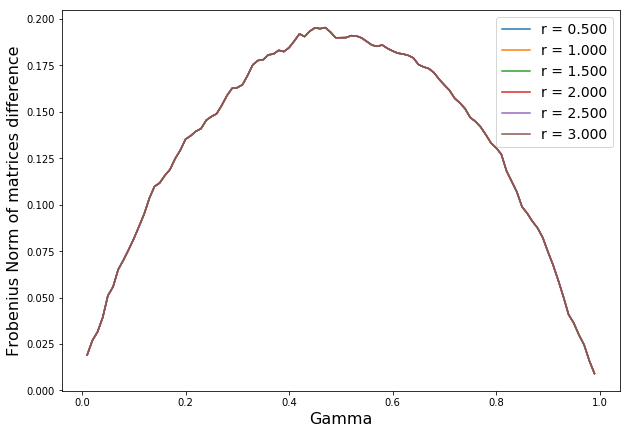

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]

for r in r_list:
    plt.plot(gamma_range, results[r])


plt.legend(['r = %.3f' % r for r in r_list], loc='best', prop={'size': 14})
plt.xlabel('Gamma', fontsize=16)
plt.ylabel('Frobenius Norm of matrices difference', fontsize=16)
pass